In [ ]:
# Modules to import

!pip install --user nipy
!pip install --user nilearn
!pip install --user seaborn
!pip install --user keras
!pip install --user imageio

# TRAINING

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import tensorflow.keras

In [3]:
'''Modules needed'''

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

# from keras import regularizers

from keras.optimizers import Adam, SGD

from keras import backend as K

# Datasource

In [4]:
import glob
import imageio
import glob
import numpy as np

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import pandas as pd

class Datasource():
    
    def __init__(self, dataset_path, subjects_path):

        zeros = len(glob.glob(f"{dataset_path}/0.0/*/*.png"))
        ones = len(glob.glob(f"{dataset_path}/1.0/*/*.png"))
        images = zeros + ones
        print(f"Loading {images} images: {zeros} with survival 0, {ones} with survial 1")

        data = []
        labels = []

        # Read subject path
        df = pd.read_csv(subjects_path)
        
        for i in range(df.shape[0]):
            
            subject = df.iloc[i,1]
            label = df.iloc[i,2]
            
            if label == 1.0:
                x_label = [0, 1]
            elif label == 0.0:
                x_label = [1, 0]
            else:
                raise Exception(f"Cannot establish what label is {label}")

            for image_path in glob.glob(f'{dataset_path}/0.0/{subject}/*.png'):
                im = imageio.imread(image_path)
                im = np.expand_dims(im, axis=2)
                data.append(im)
                labels.append(x_label)
                if x_label == 1.0:
                    raise Exception("Error bad classification")

            for image_path in glob.glob(f'{dataset_path}/1.0/{subject}/*.png'):
                im = imageio.imread(image_path)
                im = np.expand_dims(im, axis=2)
                data.append(im)
                labels.append(x_label)
                if x_label == 0.0:
                    raise Exception("Error bad classification")
            
        print(f"Max value is {np.max(data)}")

        self.data = np.asarray(data) / 255.0
        self.labels = np.asarray(labels)
    
        print(f"Data Shape: {self.data.shape}")
        
    def shuffle(self, seed=42):
        self.data, self.labels = shuffle(self.data, self.labels, random_state=seed)
        print(f"Shuffletd! Data Shape: {self.data.shape}")

    def train_and_test_split(self, test_size=0.2, seed=42):
        (self.trainX, self.testX, self.trainY, self.testY) = train_test_split(self.data, self.labels, test_size=test_size, stratify=self.labels, random_state=seed)
        print("trainX, trainY, testX, testY")
        print(self.trainX.shape, self.trainY.shape, self.testX.shape, self.testY.shape)

    def train_test_validation_split(self, validation_size=0.2, test_size=0.2, seed=42):
        (X, self.validationX, Y, self.validationY) = train_test_split(self.data, self.labels, test_size=validation_size, random_state=seed)
        (self.trainX, self.testX, self.trainY, self.testY) = train_test_split(X, Y, test_size=validation_size, random_state=seed)
        print("Train: ", (self.trainX.shape, self.trainY.shape))
        print("Test: ", (self.testX.shape, self.testY.shape))
        print("Validation: ", (self.validationX.shape, self.validationY.shape))

    def get_data_shape(self):
        return tuple(self.data.shape[1:])
    

In [5]:
"""
Return CNN
"""
def get_model(data_shape):

    # Specify shape of convolution kernel
    kernel_size = (3, 3)
    n_classes = 2

    K.clear_session()

    model = Sequential()

    model.add(Conv2D(8, kernel_size, activation='relu', input_shape=data_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(16, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(16, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(n_classes, activation='softmax'))

    # optimizer
    learning_rate = 1e-5
    adam = Adam(lr=learning_rate)
    # sgd = SGD(lr=learning_rate)

    model.compile(loss='binary_crossentropy',
                  optimizer=adam, # swap out for sgd 
                  metrics=['accuracy','binary_crossentropy'])

    # model.summary()
    
    return model

In [6]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

class Trainer():
    
    def __init__(self, datasource, model_name, log_path="logs/scalars"):
        
        # Increasing this value might speed up fitting
        self.batch_size = 16
        
        # Save model
        self.datasource = datasource

        # Save log path
        self.log_path = log_path
        
        # Save model name
        self.model_name = model_name
        
    def train(self, batch_size=16, epochs=40):

        x_train, x_test = self.datasource.trainX, self.datasource.testX
        y_train, y_test = self.datasource.trainY, self.datasource.testY
            
        # Early stopping
        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode="max", patience=5)
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=f"{self.log_path}/{self.model_name}")

        # Get fresh model
        model = get_model(self.datasource.get_data_shape())
    
        # Fit
        fit = model.fit(
                x_train, y_train, 
                epochs=epochs,
                callbacks=[tensorboard_callback, early_stopping_callback],
                validation_data=(x_test, y_test), 
                # shuffle=True,
                batch_size=self.batch_size)

        # Save trained model
        model.save(f"{self.model_name}.h5")

        # Evaluate and print (test)
        self.save_results(model, x_test, y_test)

        # Save plot
        self.save_plot(fit, f"{self.model_name}.png")
        
    def train_test_validation(self, batch_size=16, epochs=40):

        x_train, x_test, x_validation = self.datasource.trainX, self.datasource.testX, self.datasource.validationX
        y_train, y_test, y_validation = self.datasource.trainY, self.datasource.testY, self.datasource.validationY
            
        # Early stopping
        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode="max", patience=5)
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=f"{self.log_path}/{self.model_name}")

        # Get fresh model
        model = get_model(self.datasource.get_data_shape())
    
        # Fit
        fit = model.fit(
                x_train, y_train, 
                epochs=epochs,
                callbacks=[tensorboard_callback, early_stopping_callback],
                validation_data=(x_test, y_test), 
                # shuffle=True,
                batch_size=self.batch_size)

        # Save trained model
        model.save(f"{self.model_name}.h5")

        # Evaluate and print (test)
        self.save_results(model, x_test, y_test)

        # Evaluate and print (validation)
        self.save_results(model, x_validation, y_validation)

        # Save plot
        self.save_plot(fit, f"{self.model_name}.png")
                
    # Train with k-fold (5)
    def train_with_kfold(self, batch_size=16, epochs=40, n_split=5):
                        
        fold = 0
        
        for train_index, test_index in KFold(n_split).split(self.datasource.data):
            
            fold = fold + 1
            
            x_train, x_test = self.datasource.data[train_index], self.datasource.data[test_index]
            y_train, y_test = self.datasource.labels[train_index], self.datasource.labels[test_index]
            
            print(f"Starting Kfold {fold}")

            # Early stopping
            early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode="max", patience=5)
            tensorboard_callback = keras.callbacks.TensorBoard(log_dir="f{self.log_path}/{self.model_name}-{fold}")

            # Get fresh model
            model = get_model(self.datasource.get_data_shape())
    
            # Fit
            fit = model.fit(
                    x_train, y_train, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback, early_stopping_callback],
                    validation_data=(x_test, y_test), 
                    # shuffle=True,
                    batch_size=self.batch_size)

            # Save trained model
            model.save(f"{self.model_name}-{fold}.h5")

            # Evaluate and print
            self.save_results(model, x_test, y_test)

            # Save plot
            self.save_plot(fit, f"{self.model_name}-{fold}.png")
        
    def save_results(self, model, test_x, test_y):
        # evaluate the model
        scores = model.evaluate(test_x, test_y, verbose=0)
        print("-------------------------")
        print("[", self.model_name, "]")
        for i in range(len(model.metrics_names)):
            print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))
        print("-------------------------")
        
    def save_plot(self, fit, plot_path):

        fig = plt.figure(figsize=(40, 25))
        epoch = fit.epoch
        fontsize = 16

        plt.plot(fit.epoch, fit.history['accuracy'], marker="o", linewidth=2,
                 color="steelblue", label="accuracy")

        plt.plot(epoch, fit.history['loss'], marker="o", linewidth=2,
                 color="orange", label="loss")
        plt.plot(epoch, fit.history['val_accuracy'], marker="o", linewidth=2,
             color="red", label="test")
        plt.plot(epoch, fit.history['val_binary_crossentropy'], marker="o", linewidth=2,
             color="green", label="binary_crossentropy")
        plt.xlabel('epoch', fontsize=fontsize)
        plt.ylabel('% Accuracy', fontsize=fontsize)

        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.legend(frameon=False, fontsize=30);

        plt.savefig(plot_path)

# One Shot

Loading 2167 images: 1158 with survival 0, 1009 with survial 1
Max value is 255
Data Shape: (1693, 192, 256, 1)
Shuffletd! Data Shape: (1693, 192, 256, 1)
trainX, trainY, testX, testY
(1354, 192, 256, 1) (1354, 2) (339, 192, 256, 1) (339, 2)
Train on 1354 samples, validate on 339 samples
Epoch 1/40
1354/1354 [==============================] - 3s 2ms/step - loss: 0.7316 - accuracy: 0.7504 - binary_crossentropy: 0.7316 - val_loss: 0.5817 - val_accuracy: 0.8201 - val_binary_crossentropy: 0.5817
Epoch 2/40
1354/1354 [==============================] - 2s 2ms/step - loss: 0.5369 - accuracy: 0.7925 - binary_crossentropy: 0.5369 - val_loss: 0.5190 - val_accuracy: 0.8201 - val_binary_crossentropy: 0.5190
Epoch 3/40
1354/1354 [==============================] - 2s 2ms/step - loss: 0.4427 - accuracy: 0.8242 - binary_crossentropy: 0.4427 - val_loss: 0.4880 - val_accuracy: 0.8201 - val_binary_crossentropy: 0.4880
Epoch 4/40
1354/1354 [==============================] - 2s 2ms/step - loss: 0.3454 - ac

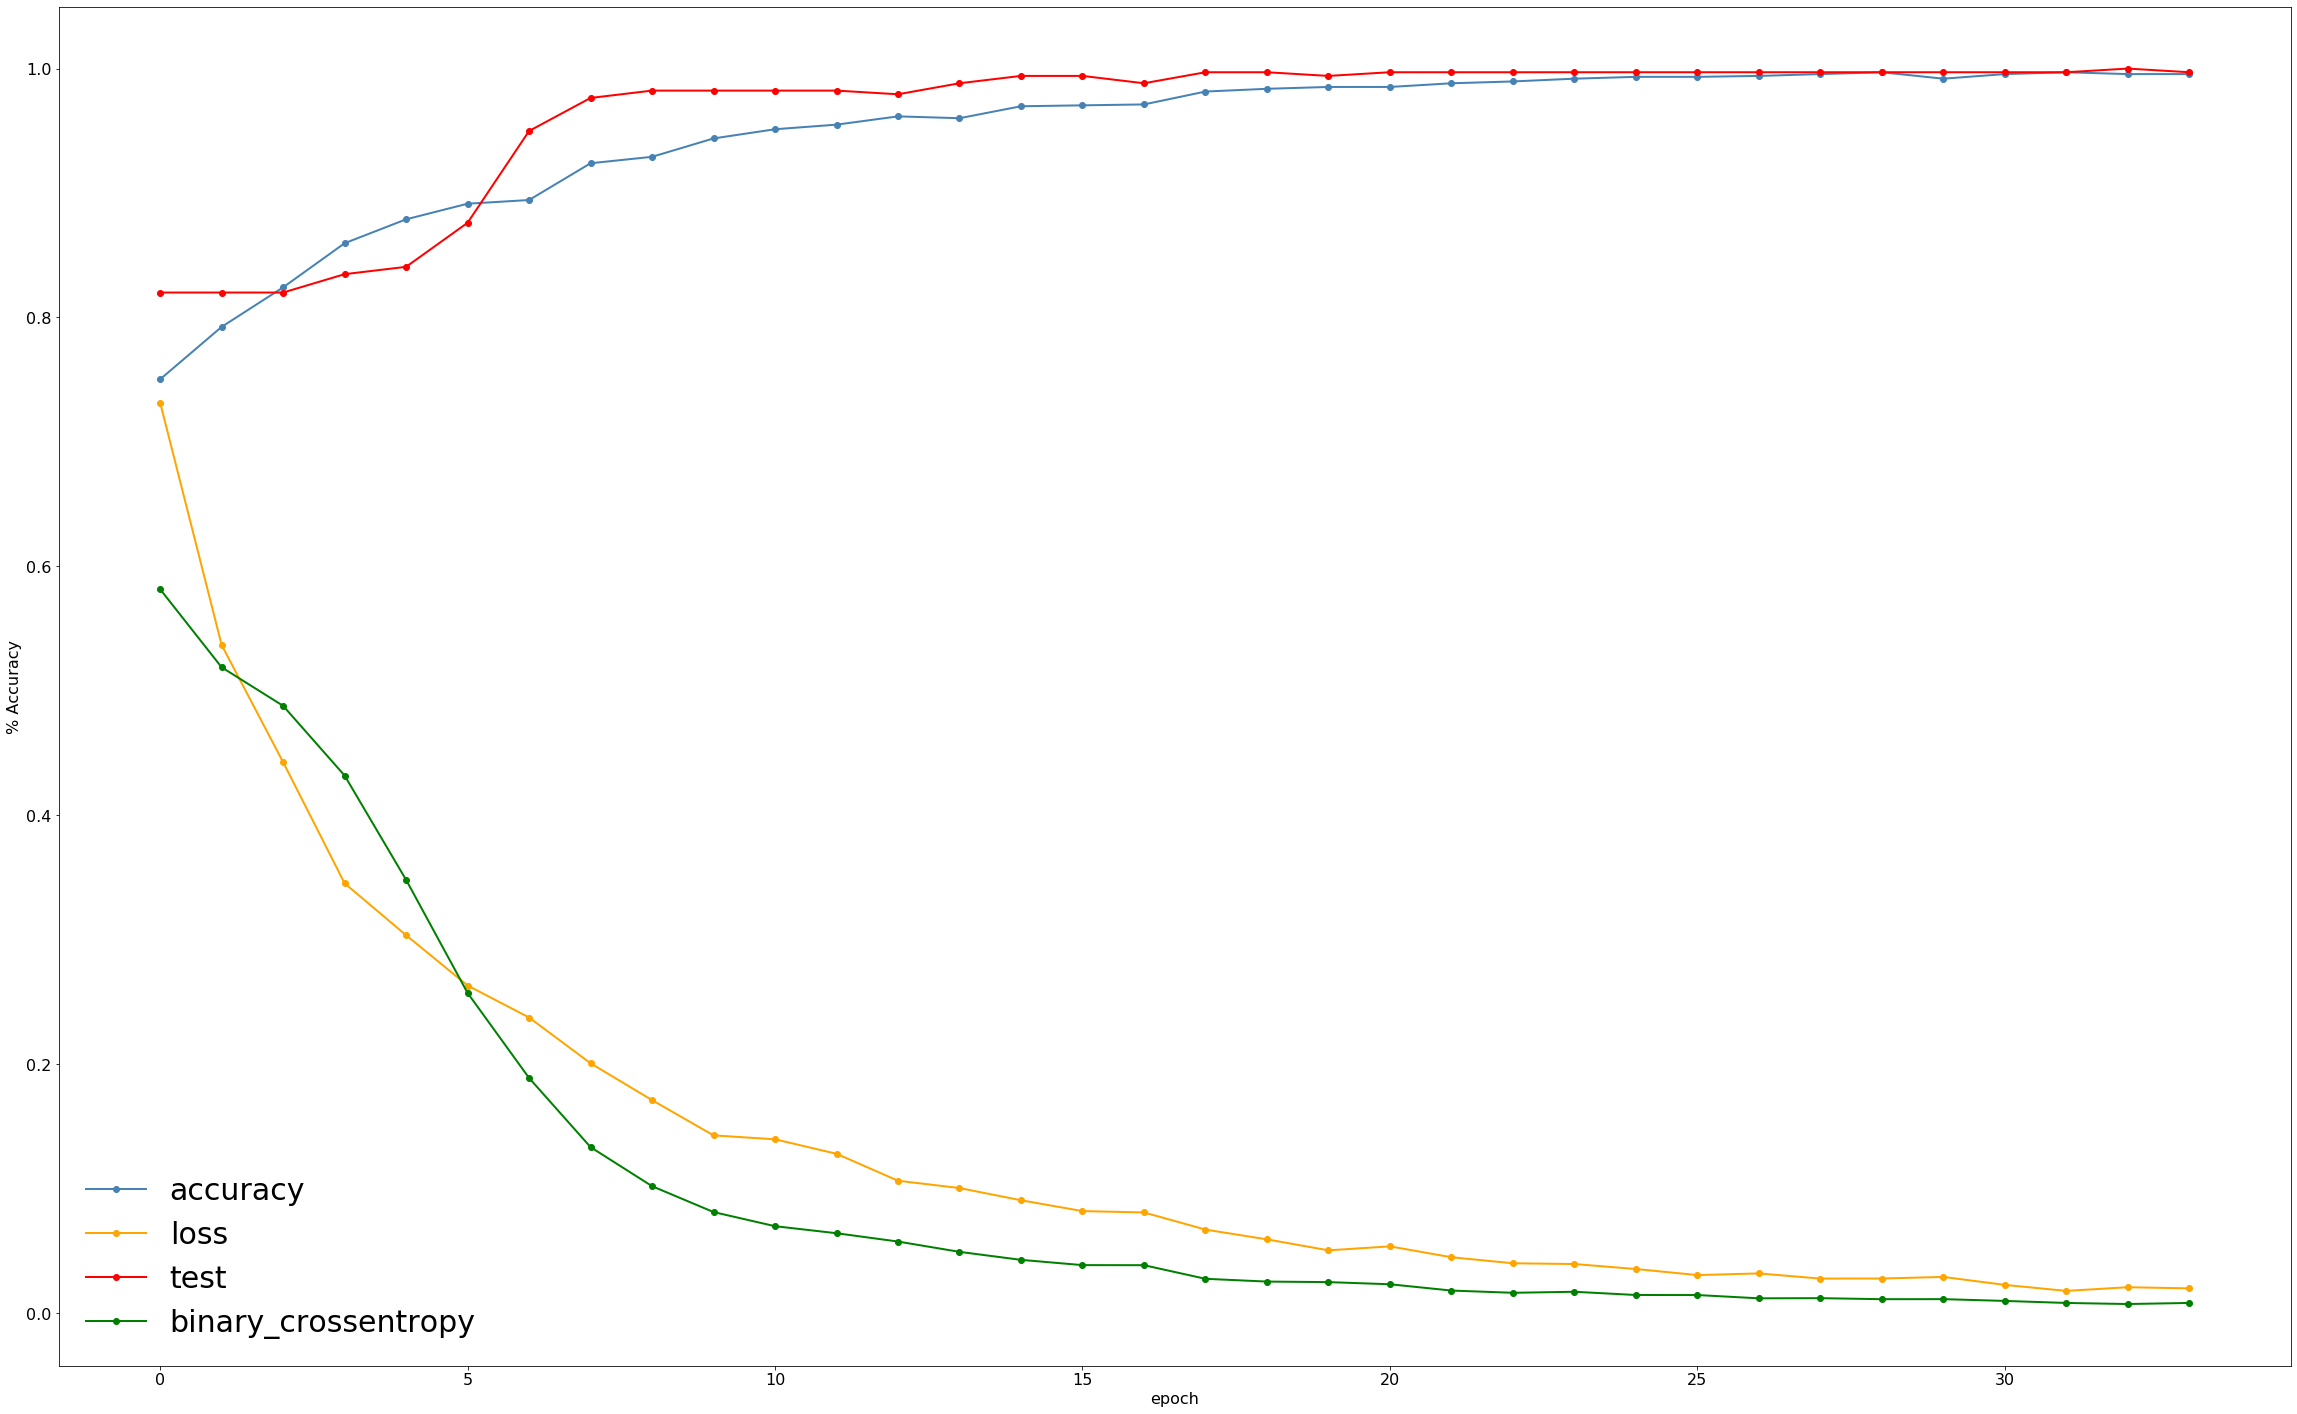

In [10]:
sequence = "T1"

percentile = 70

ds = Datasource(f"dataset-{sequence}-{percentile}", "dataset-ki67.csv")

ds.shuffle()

ds.train_and_test_split()

# Trainer
trainer = Trainer(ds, f"dataset-{sequence}-{percentile}", "model-ki67-T1-70")

trainer.train()

# Complete Train Set

In [ ]:
%%time

for sequence in ["T1", "ADC", "FLAIR"]:
    
    for percentile in [70, 50, 30]:
        
        if sequence == "T1" and percentile == 70:
            next
        
        # Read datasource
        ds = Datasource(f"dataset-{sequence}-{percentile}")

        ds.shuffle()

        ds.train_and_test_split()

        # Get model based on data shape
        model = get_model(ds.get_data_shape())

        # Trainer
        trainer = Trainer(ds, f"dataset-{sequence}-{percentile}")

        # Training
        trainer.train_with_kfold()

In [ ]:
# Final Validation

In [ ]:
%%time

sequence = "FLAIR"
    
percentile = 70
        
# Read datasource
ds = Datasource(f"dataset-{sequence}-{percentile}", "dataset-survivor.csv")

# shuffle
ds.shuffle()

# Train, test and validation
ds.train_test_validation_split()

# Trainer
trainer = Trainer(ds, f"dataset-{sequence}-{percentile}")

# Training
trainer.train()

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/scalars

In [ ]:
# evaluate the model
scores = model.evaluate(testX, testY, verbose=0)
for i in range(len(model.metrics_names)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

In [ ]:
result = model.predict(testX)

In [ ]:
for i in range(result.shape[0]):
    print(f"Answer: {testY[i]} => Prediction: {result[i].round(decimals=2)}")

In [ ]:
import tensorflow.keras as keras

new_model = keras.models.load_model('perc_70.h5')

# evaluate the model
scores = model.evaluate(testX, testY, verbose=0)
for i in range(len(model.metrics_names)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))